In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import seaborn
# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)

from matrix_operation import mat_opr
from Dataset import dataset
from state_set import state_data

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows and columns
dset.drop_zero_rows()
dset.drop_zero_cols()

# drop all rows where Big10 isn't complete
dset = dset.drop_bad_rows()

In [4]:
# NOTE: this is just so I can visualize the input along with the
#       normalized outputs. Should not be used elsewhere


n = dset.dataframe.copy(deep=True)

for i in n.columns:
    n[i] /= n[i].max()

inp = mat_opr(n).dataframe

### Interpolate using Isotonic + normalize

In [5]:
# doing isotonic first ensures that the last value is the greatest.
with_iso = dset.iso(unk=0)
normed = with_iso.normalizer()

### Choose a rank:

In [6]:
errors = []
for i in range(15):
    nmfed = normed.sci_nmf(components=i+1)
    errors.append(normed.mean_square_error(nmfed, 0))

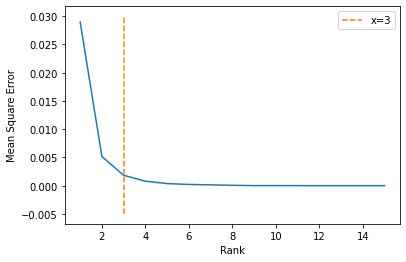

In [7]:
plt.plot(list(range(1,16)), errors)
plt.vlines(x=3, ymin=-0.005, ymax= 0.030, color="tab:orange", linestyle='dashed', label="x=3")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

In [8]:
ranker = 3

### Look at the basis vectors

In [9]:
X,Y = normed.sci_nmf(ranker, separate=True)
dotted = pd.DataFrame(np.dot(X,Y))
dotted.index = with_iso.dataframe.index
dotted.columns = with_iso.dataframe.columns
iso_nmf = mat_opr(dotted)

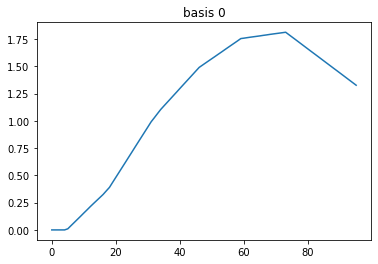

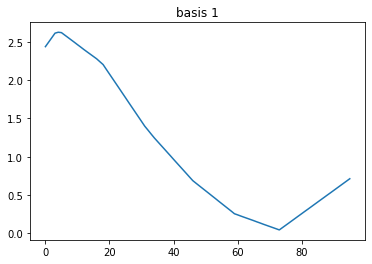

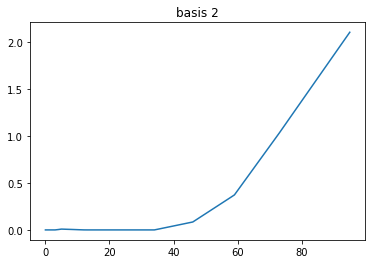

In [10]:
bases = pd.DataFrame(X)
    
for i in bases.columns:
    bases[i].plot()
    plt.title("basis " + str(i))
    plt.show()

<AxesSubplot:title={'center':'Boston University'}>

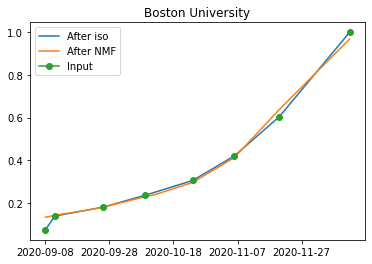

In [11]:
bu = pd.concat([inp['Boston University'],normed.dataframe['Boston University'], iso_nmf.dataframe['Boston University']], axis = 1)
bu.columns = ['Input','After iso','After NMF']

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')

bu['Input'] = bu['Input'].replace(0,np.nan)
bu['Input'].plot(marker='o',legend=True)

## Clustering

In [12]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [13]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10):
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    fig, axs = plt.subplots(len(subs), figsize=(14,11))
    clust_dict = sort_by_cluster(labels)
    
    for i in clust_dict.keys():
        if sample_size > len(clust_dict[i]):
            for j in clust_dict[i]:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
        else:
            samples = random.sample(clust_dict[i], sample_size)
            for j in samples:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
        axs[i].set_title("cluster " + str(i))
            
    if mean:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axs[k], color='k', linewidth=4.0, label='center', legend=True)
            

### Cluster on original matrix (after isotonic)

In [14]:
#kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(with_iso.array)))
#county = pd.Series(kmeans.labels_)
#plot_cluster(iso_nmf, county,mean=True, sample_size=10)

### Cluster the vectors of Y after decomposition

In [15]:
indexy = []
for i in range(ranker):
    indexy.append("basis " + str(i))

In [16]:
y_table = mat_opr(pd.DataFrame(Y, index = indexy))
y_clust = np.transpose(np.array(y_table.array))

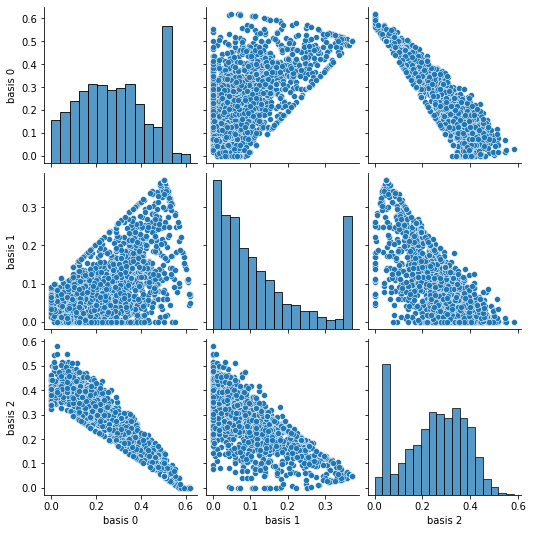

In [17]:
seaborn.pairplot(y_table.dataframe.T)

#### Number of Clusters?

For n_clusters = 2 The average silhouette_score is : 0.5365346621927148
For n_clusters = 3 The average silhouette_score is : 0.4947915414973403
For n_clusters = 4 The average silhouette_score is : 0.4353795862027717
For n_clusters = 5 The average silhouette_score is : 0.4124994943297623


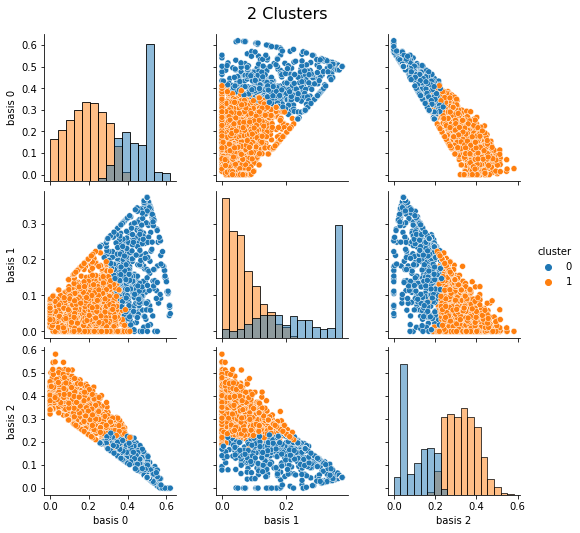

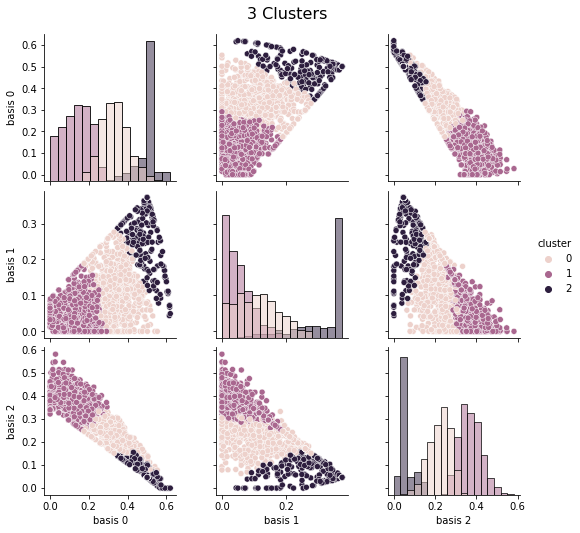

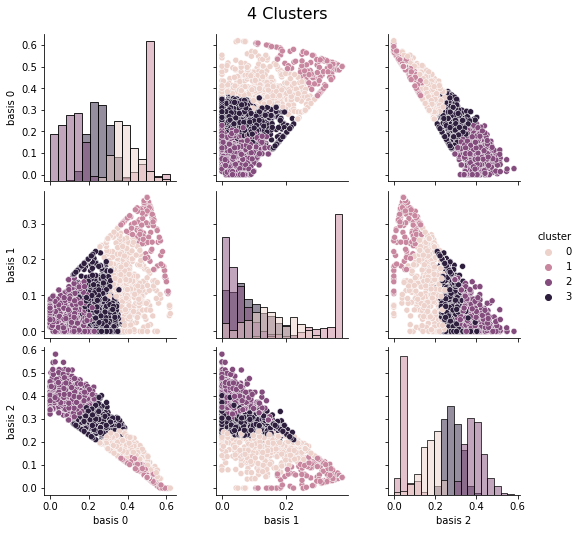

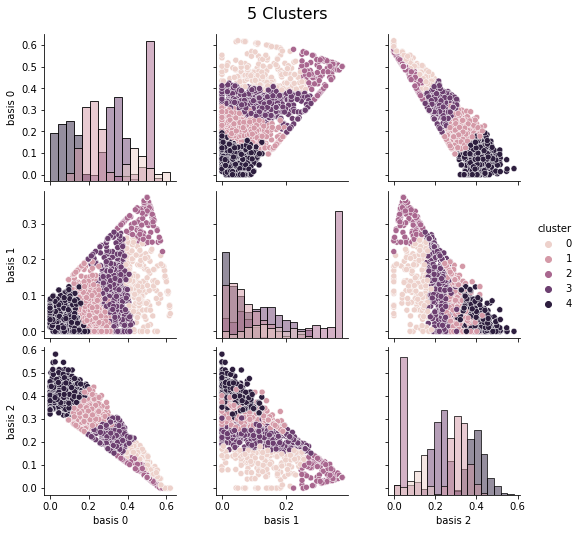

In [18]:
ns = [2,3,4,5]

for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=9).fit(y_clust)
    n_counter = pd.Series(kmeans.labels_)
    
    silhouette_avg = silhouette_score(y_clust, n_counter)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    
    n_cluster_df = y_table.dataframe.T
    n_cluster_df['cluster'] = n_counter

    pp = seaborn.pairplot(n_cluster_df, hue="cluster", diag_kind="hist")
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(str(n) + " Clusters", fontsize=16)

In [19]:
num_clust = 2

In [20]:
kmeans = KMeans(n_clusters=num_clust, random_state=9).fit(y_clust)
counter = pd.Series(kmeans.labels_)

In [21]:
print(counter.value_counts())

1    1159
0     713
dtype: int64


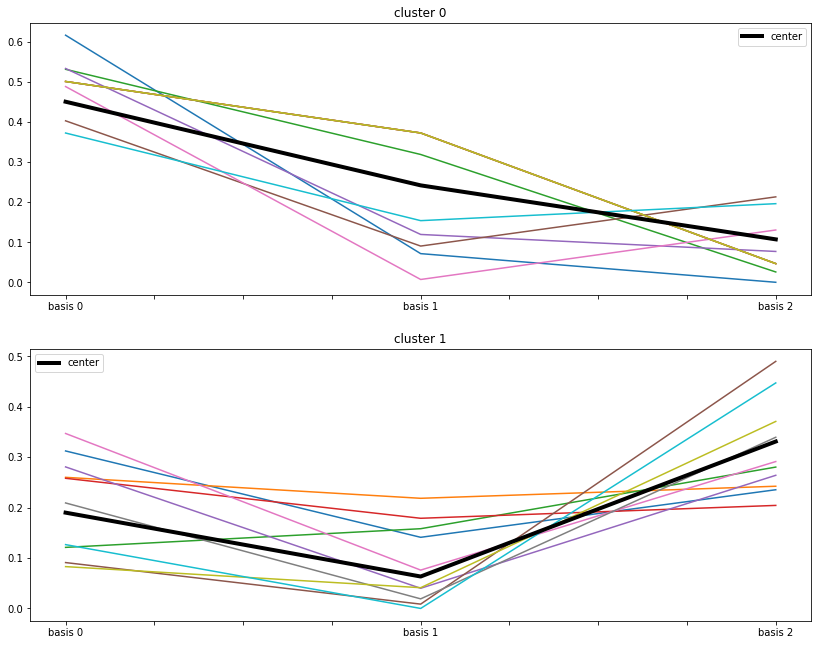

In [22]:
plot_cluster(y_table, counter, mean=True)

### Plot case curves based on their cluster of Y

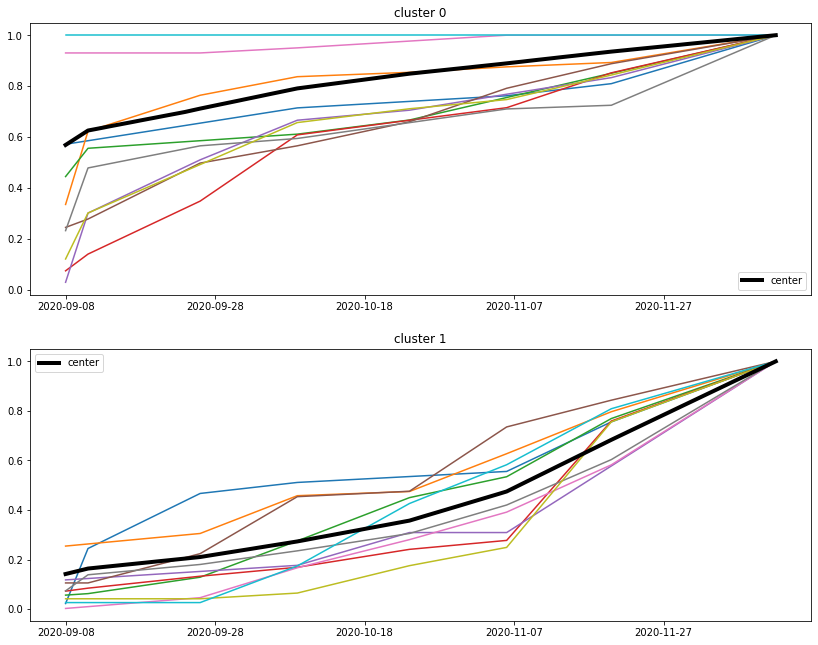

In [23]:
plot_cluster(normed, counter, mean=True)

### Plot daily increase in cases

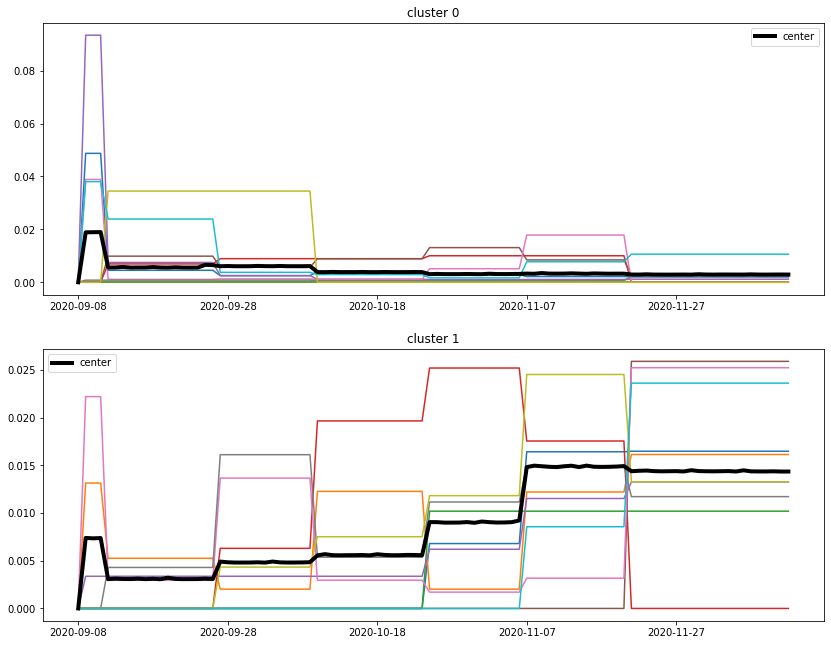

In [24]:
new_case = normed.new_case_calc()
plot_cluster(new_case, counter, mean=True)